In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

from matplotlib import cm
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

# wrangle
import wrangle
import env
import util

In [2]:
# let's me see more rows other than the first and last 5
pd.set_option("display.max_rows", 150)

Acquire

In [3]:
# acquires data from SQL database if it's not already locally saved as a .csv 
# file and combines requested tables into a dataframe using wrangle module
z_df = wrangle.get_zillow_data()
z_df.tail()

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc
52437,261.0,17115142,76623,0.004695,2017-09-14,2803929,NaN,NaN,NaN,2.0,...,NaN,153137.0,306274.0,2016.0,153137.0,3310.66,NaN,NaN,6.111002e+13,Single Family Residential
52438,261.0,10765668,76622,-0.038184,2017-09-14,2372597,1.0,NaN,NaN,3.0,...,NaN,195236.0,313705.0,2016.0,118469.0,4031.36,Y,14.0,6.037134e+13,Single Family Residential
52439,261.0,10761378,76620,0.219625,2017-09-14,2417187,1.0,NaN,NaN,2.0,...,NaN,137835.0,328340.0,2016.0,190505.0,4064.34,Y,15.0,6.037131e+13,Single Family Residential
52440,261.0,11951945,76618,-0.067738,2017-09-14,2108582,NaN,NaN,NaN,1.0,...,NaN,88455.0,395956.0,2016.0,307501.0,4759.25,NaN,NaN,6.037187e+13,Single Family Residential
52441,261.0,11784034,76617,0.025360,2017-09-14,1341842,1.0,NaN,NaN,1.0,...,NaN,126400.0,158000.0,2016.0,31600.0,2712.37,NaN,NaN,6.037207e+13,Single Family Residential


Prepare

In [4]:
# quick check of columns, nulls via non-nulls to total entries, and data types
z_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52442 non-null  float64
 1   parcelid                      52442 non-null  int64  
 2   id                            52442 non-null  int64  
 3   logerror                      52442 non-null  float64
 4   transactiondate               52442 non-null  object 
 5   id.1                          52442 non-null  int64  
 6   airconditioningtypeid         13638 non-null  float64
 7   architecturalstyletypeid      70 non-null     float64
 8   basementsqft                  47 non-null     float64
 9   bathroomcnt                   52442 non-null  float64
 10  bedroomcnt                    52442 non-null  float64
 11  buildingclasstypeid           0 non-null      float64
 12  buildingqualitytypeid         33741 non-null  float64
 13  c

In [5]:
# custom function that gets the number of rows, columns, and number of rows with
# nulls for each column.  Also returns description for common values from table
util.metrics(z_df)

There are 52442 rows and 63 columns in this dataframe.
Plus the following nulls:
propertylandusetypeid               0
parcelid                            0
id                                  0
logerror                            0
transactiondate                     0
id.1                                0
airconditioningtypeid           38804
architecturalstyletypeid        52372
basementsqft                    52395
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             52442
buildingqualitytypeid           18701
calculatedbathnbr                 137
decktypeid                      52053
finishedfloor1squarefeet        48061
calculatedfinishedsquarefeet       82
finishedsquarefeet12              247
finishedsquarefeet13            52442
finishedsquarefeet15            52442
finishedsquarefeet50            48061
finishedsquarefeet6             52277
fips                                0
fireplacecnt                    45199
fullbat

,count,mean,std,min,25%,50%,75%,max
propertylandusetypeid,52442.0,2.610000e+02,0.000000e+00,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
parcelid,52442.0,1.299912e+07,3.411412e+06,1.071186e+07,1.151030e+07,1.257766e+07,1.412951e+07,1.676878e+08
id,52442.0,3.886063e+04,2.234844e+04,0.000000e+00,1.954625e+04,3.892750e+04,5.809350e+04,7.761300e+04
logerror,52442.0,1.829437e-02,1.775018e-01,-4.655420e+00,-2.463935e-02,7.009984e-03,4.069098e-02,5.262999e+00
id.1,52442.0,1.497288e+06,8.594413e+05,3.490000e+02,7.579560e+05,1.500836e+06,2.241564e+06,2.982270e+06
airconditioningtypeid,13638.0,2.438041e+00,3.846176e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52442.0,2.299397e+00,1.022764e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52442.0,3.300675e+00,9.490858e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01


In [6]:
# shows how many duplicate entries we have for parcelids which should be unique
# unless it's been sold multiple times in 2017
z_df.parcelid.duplicated().sum()

122

In [7]:
# shows the duplicate rows of parcelids and their respective transaction dates
dupe_pid = z_df[z_df.parcelid.duplicated(keep=False)]
dupe_pid[['parcelid', 'transactiondate']].sort_values(by='parcelid')

,parcelid,transactiondate
8588,10722858,2017-07-28
8589,10722858,2017-03-02
8667,10732347,2017-03-01
8666,10732347,2017-07-25
1878,10739478,2017-01-13
...,...,...
25379,17280166,2017-05-23
43367,17282392,2017-08-07
43366,17282392,2017-08-25
23182,162960529,2017-05-26


In [8]:
dupe_pid = dupe_pid.sort_values(by='transactiondate')
dupe_pid

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc
1381,261.0,11721753,1017,-0.011052,2017-01-05,616260,NaN,NaN,NaN,2.0,...,NaN,41948.0,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,Single Family Residential
1218,261.0,11289917,1247,0.227903,2017-01-06,2061546,1.0,NaN,NaN,2.0,...,NaN,108890.0,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,Single Family Residential
672,261.0,14269464,2027,0.012505,2017-01-10,1923117,NaN,NaN,NaN,3.0,...,NaN,434887.0,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,Single Family Residential
857,261.0,11705026,1771,-0.034286,2017-01-10,1834372,NaN,NaN,NaN,1.0,...,NaN,11982.0,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,Single Family Residential
2023,261.0,11446756,2680,0.064044,2017-01-12,451211,NaN,NaN,NaN,2.0,...,NaN,60537.0,107110.0,2016.0,46573.0,1399.27,NaN,NaN,6.037650e+13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12684,261.0,13863275,18400,2.322401,2017-09-14,2604936,NaN,NaN,NaN,1.0,...,NaN,360175.0,1694922.0,2016.0,1334747.0,18789.34,NaN,NaN,6.059099e+13,Single Family Residential
23491,261.0,10979425,33837,-0.241779,2017-09-18,1416119,1.0,NaN,NaN,3.0,...,NaN,177734.0,370842.0,2016.0,193108.0,4658.25,Y,15.0,6.037106e+13,Single Family Residential
4344,261.0,12478591,7091,0.039378,2017-09-18,1535169,1.0,NaN,NaN,3.0,...,NaN,212000.0,612000.0,2016.0,400000.0,7204.93,NaN,NaN,6.037554e+13,Single Family Residential
7356,261.0,11957553,10543,-0.116322,2017-09-19,1094342,NaN,NaN,NaN,1.0,...,NaN,91000.0,455000.0,2016.0,364000.0,5479.50,NaN,NaN,6.037185e+13,Single Family Residential


In [9]:
dupe_pid = z_df[z_df.duplicated(subset=['transactiondate'], keep='last')]
dupe_pid

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc
0,261.0,12612840,889,0.079772,2017-01-05,1514581,NaN,NaN,NaN,2.0,...,NaN,29440.0,63380.0,2016.0,33940.0,1104.70,NaN,NaN,6.037670e+13,Single Family Residential
1,261.0,12611007,888,0.100001,2017-01-05,216904,NaN,NaN,NaN,2.0,...,NaN,71733.0,182691.0,2016.0,110958.0,2506.91,NaN,NaN,6.037670e+13,Single Family Residential
2,261.0,12023386,886,-0.006511,2017-01-05,304078,NaN,NaN,NaN,2.0,...,NaN,52583.0,87557.0,2016.0,34974.0,1229.29,NaN,NaN,6.037194e+13,Single Family Residential
3,261.0,11647399,883,0.006355,2017-01-05,1943418,NaN,NaN,NaN,4.0,...,NaN,337583.0,1687919.0,2016.0,1350336.0,20436.93,NaN,NaN,6.037265e+13,Single Family Residential
4,261.0,10780171,882,-0.059383,2017-01-05,90918,1.0,NaN,NaN,3.0,...,NaN,167789.0,225746.0,2016.0,57957.0,2851.71,NaN,NaN,6.037133e+13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52436,261.0,12348184,76626,0.021500,2017-09-14,2303594,1.0,NaN,NaN,3.0,...,NaN,229420.0,429684.0,2016.0,200264.0,5426.24,NaN,NaN,6.037553e+13,Single Family Residential
52437,261.0,17115142,76623,0.004695,2017-09-14,2803929,NaN,NaN,NaN,2.0,...,NaN,153137.0,306274.0,2016.0,153137.0,3310.66,NaN,NaN,6.111002e+13,Single Family Residential
52438,261.0,10765668,76622,-0.038184,2017-09-14,2372597,1.0,NaN,NaN,3.0,...,NaN,195236.0,313705.0,2016.0,118469.0,4031.36,Y,14.0,6.037134e+13,Single Family Residential
52439,261.0,10761378,76620,0.219625,2017-09-14,2417187,1.0,NaN,NaN,2.0,...,NaN,137835.0,328340.0,2016.0,190505.0,4064.34,Y,15.0,6.037131e+13,Single Family Residential


Dropped duplicate rows of parcelid based on latest transaction date

In [10]:
# sorted df by transaction date
z_df = z_df.sort_values(by='transactiondate')
z_df

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc
585,261.0,14297519,0,0.025595,2017-01-01,1727539,NaN,NaN,NaN,3.5,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,Single Family Residential
584,261.0,17052889,1,0.055619,2017-01-01,1387261,NaN,NaN,NaN,1.0,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,Single Family Residential
583,261.0,14186244,2,0.005383,2017-01-01,11677,NaN,NaN,NaN,2.0,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,Single Family Residential
582,261.0,12177905,3,-0.103410,2017-01-01,2288172,NaN,NaN,NaN,3.0,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,Single Family Residential
581,261.0,12095076,6,-0.001011,2017-01-01,781532,1.0,NaN,NaN,3.0,...,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,261.0,11000655,77609,0.020615,2017-09-20,673515,NaN,NaN,NaN,2.0,...,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,Single Family Residential
51814,261.0,17239384,77610,0.013209,2017-09-21,2968375,NaN,NaN,NaN,2.0,...,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,Single Family Residential
51813,261.0,12773139,77611,0.037129,2017-09-21,1843709,1.0,NaN,NaN,1.0,...,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,Single Family Residential
51812,261.0,12826780,77612,0.007204,2017-09-25,1187175,NaN,NaN,NaN,2.0,...,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,Single Family Residential


In [11]:
# drops all but the last duplicate row by parcelid
z_df = z_df.drop_duplicates(subset=['parcelid'], keep='last')
z_df

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc
585,261.0,14297519,0,0.025595,2017-01-01,1727539,NaN,NaN,NaN,3.5,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,Single Family Residential
584,261.0,17052889,1,0.055619,2017-01-01,1387261,NaN,NaN,NaN,1.0,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,Single Family Residential
583,261.0,14186244,2,0.005383,2017-01-01,11677,NaN,NaN,NaN,2.0,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,Single Family Residential
582,261.0,12177905,3,-0.103410,2017-01-01,2288172,NaN,NaN,NaN,3.0,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,Single Family Residential
581,261.0,12095076,6,-0.001011,2017-01-01,781532,1.0,NaN,NaN,3.0,...,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,261.0,11000655,77609,0.020615,2017-09-20,673515,NaN,NaN,NaN,2.0,...,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,Single Family Residential
51814,261.0,17239384,77610,0.013209,2017-09-21,2968375,NaN,NaN,NaN,2.0,...,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,Single Family Residential
51813,261.0,12773139,77611,0.037129,2017-09-21,1843709,1.0,NaN,NaN,1.0,...,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,Single Family Residential
51812,261.0,12826780,77612,0.007204,2017-09-25,1187175,NaN,NaN,NaN,2.0,...,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,Single Family Residential


In [12]:
# checks percentage of relative null values for each column
z_df.isna().mean()

propertylandusetypeid           0.000000
parcelid                        0.000000
id                              0.000000
logerror                        0.000000
transactiondate                 0.000000
id.1                            0.000000
airconditioningtypeid           0.739774
architecturalstyletypeid        0.998662
basementsqft                    0.999102
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingclasstypeid             1.000000
buildingqualitytypeid           0.356747
calculatedbathnbr               0.002580
decktypeid                      0.992565
finishedfloor1squarefeet        0.916456
calculatedfinishedsquarefeet    0.001548
finishedsquarefeet12            0.004702
finishedsquarefeet13            1.000000
finishedsquarefeet15            1.000000
finishedsquarefeet50            0.916456
finishedsquarefeet6             0.996846
fips                            0.000000
fireplacecnt                    0.861755
fullbathcnt     

In [13]:
# shows the number of items for the values in each column most most to least
util.get_numbers(z_df)

propertylandusetypeid
261.0    52320
Name: propertylandusetypeid, dtype: int64
-----------------
parcelid
14297519    1
11874371    1
14010021    1
12496785    1
10808525    1
           ..
14002654    1
12168606    1
12742929    1
10757867    1
13083743    1
Name: parcelid, Length: 52320, dtype: int64
-----------------
id
0        1
52024    1
52010    1
52012    1
52015    1
        ..
26046    1
25999    1
26047    1
25998    1
77613    1
Name: id, Length: 52320, dtype: int64
-----------------
logerror
 0.002652    5
 0.000727    5
 0.001878    5
 0.000231    5
 0.018974    4
            ..
-0.018878    1
-0.069824    1
 0.017325    1
-0.012495    1
-0.197755    1
Name: logerror, Length: 52061, dtype: int64
-----------------
transactiondate
2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-04-08      1
2017-03-25      1
2017-03-12      1
2017-03-11      1
2018-05-25      1
Name: transactiondate, Length: 258, dtype: int64

In [14]:
# shows which columns have 2% or more null values
util.get_nan_cols(z_df, nan_percent=0.02)

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'regionidneighborhood',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [15]:
# gets rid of any columns with more that 2% null values
z_df = wrangle.percentage_dropper(z_df)


In [16]:
# shows updated info of the remaining columns
z_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52320 entries, 585 to 51811
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52320 non-null  float64
 1   parcelid                      52320 non-null  int64  
 2   id                            52320 non-null  int64  
 3   logerror                      52320 non-null  float64
 4   transactiondate               52320 non-null  object 
 5   id.1                          52320 non-null  int64  
 6   bathroomcnt                   52320 non-null  float64
 7   bedroomcnt                    52320 non-null  float64
 8   calculatedbathnbr             52185 non-null  float64
 9   calculatedfinishedsquarefeet  52239 non-null  float64
 10  finishedsquarefeet12          52074 non-null  float64
 11  fips                          52320 non-null  float64
 12  fullbathcnt                   52185 non-null  float64
 13 

In [17]:
util.get_numbers(z_df)

propertylandusetypeid
261.0    52320
Name: propertylandusetypeid, dtype: int64
-----------------
parcelid
14297519    1
11874371    1
14010021    1
12496785    1
10808525    1
           ..
14002654    1
12168606    1
12742929    1
10757867    1
13083743    1
Name: parcelid, Length: 52320, dtype: int64
-----------------
id
0        1
52024    1
52010    1
52012    1
52015    1
        ..
26046    1
25999    1
26047    1
25998    1
77613    1
Name: id, Length: 52320, dtype: int64
-----------------
logerror
 0.002652    5
 0.000727    5
 0.001878    5
 0.000231    5
 0.018974    4
            ..
-0.018878    1
-0.069824    1
 0.017325    1
-0.012495    1
-0.197755    1
Name: logerror, Length: 52061, dtype: int64
-----------------
transactiondate
2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-04-08      1
2017-03-25      1
2017-03-12      1
2017-03-11      1
2018-05-25      1
Name: transactiondate, Length: 258, dtype: int64

In [18]:
z_df.head(10)

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc
585,261.0,14297519,0,0.025595,2017-01-01,1727539,3.5,4.0,3.5,3100.0,...,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,Single Family Residential
584,261.0,17052889,1,0.055619,2017-01-01,1387261,1.0,2.0,1.0,1465.0,...,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,Single Family Residential
583,261.0,14186244,2,0.005383,2017-01-01,11677,2.0,3.0,2.0,1243.0,...,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,Single Family Residential
582,261.0,12177905,3,-0.103410,2017-01-01,2288172,3.0,4.0,3.0,2376.0,...,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,Single Family Residential
581,261.0,12095076,6,-0.001011,2017-01-01,781532,3.0,4.0,3.0,2962.0,...,96293.0,0.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,Single Family Residential
580,261.0,12069064,7,0.101723,2017-01-01,870991,1.0,2.0,1.0,738.0,...,96325.0,0.0,1922.0,18890.0,218552.0,2016.0,199662.0,2366.08,6.037302e+13,Single Family Residential
527,261.0,12579560,86,-0.025721,2017-01-02,843278,1.0,2.0,1.0,1027.0,...,96229.0,0.0,1951.0,27521.0,49034.0,2016.0,21513.0,1179.11,6.037544e+13,Single Family Residential
534,261.0,13069118,76,-0.006370,2017-01-02,2038421,4.0,5.0,4.0,5900.0,...,96522.0,0.0,1989.0,559288.0,737397.0,2016.0,178109.0,8924.13,6.037403e+13,Single Family Residential
535,261.0,12879860,75,0.000161,2017-01-02,2887122,1.0,2.0,1.0,1046.0,...,96506.0,0.0,1885.0,46400.0,232000.0,2016.0,185600.0,3002.30,6.037403e+13,Single Family Residential
536,261.0,12871444,73,0.036263,2017-01-02,2603857,2.0,3.0,2.0,1059.0,...,96507.0,0.0,1955.0,51776.0,187119.0,2016.0,135343.0,2481.45,6.037402e+13,Single Family Residential


In [19]:
z_df.isna().sum()

propertylandusetypeid              0
parcelid                           0
id                                 0
logerror                           0
transactiondate                    0
id.1                               0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                135
calculatedfinishedsquarefeet      81
finishedsquarefeet12             246
fips                               0
fullbathcnt                      135
latitude                           0
longitude                          0
lotsizesquarefeet                366
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1036
regionidcounty                     0
regionidzip                       26
roomcnt                            0
yearbuilt                        114
structuretaxvaluedollarcnt        82
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
t

In [20]:
z_df.drop_duplicates(inplace=True)
z_df

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc
585,261.0,14297519,0,0.025595,2017-01-01,1727539,3.5,4.0,3.5,3100.0,...,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,Single Family Residential
584,261.0,17052889,1,0.055619,2017-01-01,1387261,1.0,2.0,1.0,1465.0,...,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,Single Family Residential
583,261.0,14186244,2,0.005383,2017-01-01,11677,2.0,3.0,2.0,1243.0,...,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,Single Family Residential
582,261.0,12177905,3,-0.103410,2017-01-01,2288172,3.0,4.0,3.0,2376.0,...,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,Single Family Residential
581,261.0,12095076,6,-0.001011,2017-01-01,781532,3.0,4.0,3.0,2962.0,...,96293.0,0.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,261.0,11000655,77609,0.020615,2017-09-20,673515,2.0,2.0,2.0,1286.0,...,96284.0,0.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,Single Family Residential
51814,261.0,17239384,77610,0.013209,2017-09-21,2968375,2.0,4.0,2.0,1612.0,...,97116.0,7.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,Single Family Residential
51813,261.0,12773139,77611,0.037129,2017-09-21,1843709,1.0,3.0,1.0,1032.0,...,96480.0,0.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,Single Family Residential
51812,261.0,12826780,77612,0.007204,2017-09-25,1187175,2.0,3.0,2.0,1762.0,...,96171.0,0.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,Single Family Residential


In [21]:
z_df.isna().sum()

propertylandusetypeid              0
parcelid                           0
id                                 0
logerror                           0
transactiondate                    0
id.1                               0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                135
calculatedfinishedsquarefeet      81
finishedsquarefeet12             246
fips                               0
fullbathcnt                      135
latitude                           0
longitude                          0
lotsizesquarefeet                366
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1036
regionidcounty                     0
regionidzip                       26
roomcnt                            0
yearbuilt                        114
structuretaxvaluedollarcnt        82
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
t

In [22]:
z_df = wrangle.handle_nulls(z_df)

In [23]:
z_df.isna().sum()

propertylandusetypeid           0
parcelid                        0
id                              0
logerror                        0
transactiondate                 0
id.1                            0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandus

In [24]:
z_df

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc
585,261.0,14297519,0,0.025595,2017-01-01,1727539,3.5,4.0,3.5,3100.0,...,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,Single Family Residential
584,261.0,17052889,1,0.055619,2017-01-01,1387261,1.0,2.0,1.0,1465.0,...,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,Single Family Residential
583,261.0,14186244,2,0.005383,2017-01-01,11677,2.0,3.0,2.0,1243.0,...,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,Single Family Residential
582,261.0,12177905,3,-0.103410,2017-01-01,2288172,3.0,4.0,3.0,2376.0,...,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,Single Family Residential
581,261.0,12095076,6,-0.001011,2017-01-01,781532,3.0,4.0,3.0,2962.0,...,96293.0,0.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,261.0,11000655,77609,0.020615,2017-09-20,673515,2.0,2.0,2.0,1286.0,...,96284.0,0.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,Single Family Residential
51814,261.0,17239384,77610,0.013209,2017-09-21,2968375,2.0,4.0,2.0,1612.0,...,97116.0,7.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,Single Family Residential
51813,261.0,12773139,77611,0.037129,2017-09-21,1843709,1.0,3.0,1.0,1032.0,...,96480.0,0.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,Single Family Residential
51812,261.0,12826780,77612,0.007204,2017-09-25,1187175,2.0,3.0,2.0,1762.0,...,96171.0,0.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,Single Family Residential


In [25]:
z_df = wrangle.clean_zillow(z_df)


In [26]:
util.metrics(z_df)

There are 50560 rows and 21 columns in this dataframe.
Plus the following nulls:
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
county                          0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
parcelid,50560.0,1.295981e+07,2.195740e+06,1.071186e+07,1.152888e+07,1.258235e+07,1.412914e+07,1.629608e+08
logerror,50560.0,1.811490e-02,1.750647e-01,-4.655420e+00,-2.475762e-02,6.838764e-03,4.034852e-02,5.262999e+00
bathroomcnt,50560.0,2.293186e+00,1.003989e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
bedroomcnt,50560.0,3.304490e+00,9.271340e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
calculatedfinishedsquarefeet,50560.0,1.912129e+03,9.897919e+02,1.520000e+02,1.268000e+03,1.651000e+03,2.286000e+03,2.192900e+04
fips,50560.0,6.049197e+03,2.117453e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,50560.0,3.402158e+07,2.716998e+05,3.334085e+07,3.382823e+07,3.402175e+07,3.418533e+07,3.481877e+07
longitude,50560.0,-1.181951e+08,3.559258e+05,-1.194753e+08,-1.183981e+08,-1.181536e+08,-1.179309e+08,-1.175723e+08
lotsizesquarefeet,50560.0,1.108385e+04,8.744150e+04,2.360000e+02,5.576000e+03,6.825000e+03,8.750000e+03,6.971010e+06
rawcensustractandblock,50560.0,6.049504e+07,2.101650e+05,6.037101e+07,6.037400e+07,6.037603e+07,6.059042e+07,6.111009e+07


In [27]:
# 100% of regionidcity can lose the deicimal and be OK
(z_df.regionidcity == z_df.regionidcity.astype(int)).mean()

1.0

In [28]:
# 100% of regionidzip can lose the deicimal and be OK
(z_df.regionidzip == z_df.regionidzip.astype(int)).mean()

1.0

In [29]:
# 100% of structuretaxvaluedollarcnt can lose the deicimal and be OK
(z_df.structuretaxvaluedollarcnt == z_df.structuretaxvaluedollarcnt.astype(int)).mean()

1.0

In [30]:
# 100% of landtaxvaluedollarcnt can lose the deicimal and be OK
(z_df.landtaxvaluedollarcnt == z_df.landtaxvaluedollarcnt.astype(int)).mean()

1.0

In [31]:
# 100% of censustractandblock can lose the deicimal and be OK
(z_df.censustractandblock == z_df.censustractandblock.astype(int)).mean()

1.0

In [32]:
z_df["transactiondate"] = pd.to_datetime(z_df["transactiondate"])
z_df[["transactiondate"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50560 entries, 585 to 51811
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   transactiondate  50560 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 790.0 KB


In [33]:
util.metrics(z_df)

There are 50560 rows and 21 columns in this dataframe.
Plus the following nulls:
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
county                          0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
parcelid,50560.0,1.295981e+07,2.195740e+06,1.071186e+07,1.152888e+07,1.258235e+07,1.412914e+07,1.629608e+08
logerror,50560.0,1.811490e-02,1.750647e-01,-4.655420e+00,-2.475762e-02,6.838764e-03,4.034852e-02,5.262999e+00
bathroomcnt,50560.0,2.293186e+00,1.003989e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
bedroomcnt,50560.0,3.304490e+00,9.271340e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
calculatedfinishedsquarefeet,50560.0,1.912129e+03,9.897919e+02,1.520000e+02,1.268000e+03,1.651000e+03,2.286000e+03,2.192900e+04
fips,50560.0,6.049197e+03,2.117453e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,50560.0,3.402158e+07,2.716998e+05,3.334085e+07,3.382823e+07,3.402175e+07,3.418533e+07,3.481877e+07
longitude,50560.0,-1.181951e+08,3.559258e+05,-1.194753e+08,-1.183981e+08,-1.181536e+08,-1.179309e+08,-1.175723e+08
lotsizesquarefeet,50560.0,1.108385e+04,8.744150e+04,2.360000e+02,5.576000e+03,6.825000e+03,8.750000e+03,6.971010e+06
rawcensustractandblock,50560.0,6.049504e+07,2.101650e+05,6.037101e+07,6.037400e+07,6.037603e+07,6.059042e+07,6.111009e+07


In [34]:
z_df.isna().mean()

parcelid                        0.0
logerror                        0.0
transactiondate                 0.0
bathroomcnt                     0.0
bedroomcnt                      0.0
calculatedfinishedsquarefeet    0.0
fips                            0.0
latitude                        0.0
longitude                       0.0
lotsizesquarefeet               0.0
propertycountylandusecode       0.0
rawcensustractandblock          0.0
regionidcity                    0.0
regionidzip                     0.0
yearbuilt                       0.0
structuretaxvaluedollarcnt      0.0
taxvaluedollarcnt               0.0
landtaxvaluedollarcnt           0.0
taxamount                       0.0
censustractandblock             0.0
county                          0.0
dtype: float64

In [35]:
z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,county
585,14297519,0.025595,2017-01-01,3.5,4,3100,6059,33634931.0,-117869207.0,4506,...,6.059063e+07,53571,96978,1998,485713,1023282,537569,11013.72,60590630072012,6059
584,17052889,0.055619,2017-01-01,1.0,2,1465,6111,34449266.0,-119281531.0,12647,...,6.111001e+07,13091,97099,1967,88000,464000,376000,5672.48,61110010023006,6111
583,14186244,0.005383,2017-01-01,2.0,3,1243,6059,33886168.0,-117823170.0,8432,...,6.059022e+07,21412,97078,1962,85289,564778,479489,6488.30,60590218022012,6059
582,12177905,-0.103410,2017-01-01,3.0,4,2376,6037,34245180.0,-118240722.0,13038,...,6.037300e+07,396551,96330,1970,108918,145143,36225,1777.51,60373001001006,6037
581,12095076,-0.001011,2017-01-01,3.0,4,2962,6037,34145202.0,-118179824.0,63000,...,6.037461e+07,47019,96293,1950,276684,773303,496619,9516.26,60374608001014,6037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,11000655,0.020615,2017-09-20,2.0,2,1286,6037,34245368.0,-118282383.0,47405,...,6.037101e+07,12447,96284,1940,70917,354621,283704,4478.43,60371014003002,6037
51814,17239384,0.013209,2017-09-21,2.0,4,1612,6111,34300140.0,-118706327.0,12105,...,6.111008e+07,27110,97116,1964,50683,67205,16522,1107.48,61110084022016,6111
51813,12773139,0.037129,2017-09-21,1.0,3,1032,6037,34040895.0,-118038169.0,5074,...,6.037434e+07,36502,96480,1954,32797,49546,16749,876.43,60374338022005,6037
51812,12826780,0.007204,2017-09-25,2.0,3,1762,6037,33937685.0,-117996709.0,6347,...,6.037503e+07,14634,96171,1955,140000,522000,382000,6317.15,60375034021020,6037


In [36]:
z_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50560 entries, 585 to 51811
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      50560 non-null  int64         
 1   logerror                      50560 non-null  float64       
 2   transactiondate               50560 non-null  datetime64[ns]
 3   bathroomcnt                   50560 non-null  float64       
 4   bedroomcnt                    50560 non-null  int64         
 5   calculatedfinishedsquarefeet  50560 non-null  int64         
 6   fips                          50560 non-null  int64         
 7   latitude                      50560 non-null  float64       
 8   longitude                     50560 non-null  float64       
 9   lotsizesquarefeet             50560 non-null  int64         
 10  propertycountylandusecode     50560 non-null  object        
 11  rawcensustractandblock    

In [37]:
no_outliers_z_df = z_df.apply(lambda x: stats.zscore(x) if x.name in ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 
'landtaxvaluedollarcnt', 'taxamount'] else x)
no_outliers_z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,county
585,14297519,0.025595,2017-01-01,1.202030,0.750180,1.200134,6059,33634931.0,-117869207.0,-0.075226,...,6.059063e+07,53571,96978,1998,1.166884,0.703176,0.401423,0.564856,60590630072012,6059
584,17052889,0.055619,2017-01-01,-1.288061,-1.407027,-0.451744,6111,34449266.0,-119281531.0,0.017877,...,6.111001e+07,13091,97099,1967,-0.419445,-0.081351,0.090706,-0.081594,61110010023006,6111
583,14186244,0.005383,2017-01-01,-0.292024,-0.328424,-0.676036,6059,33886168.0,-117823170.0,-0.030327,...,6.059022e+07,21412,97078,1962,-0.430258,0.060014,0.289728,0.017145,60590218022012,6059
582,12177905,-0.103410,2017-01-01,0.704012,0.750180,0.468660,6037,34245180.0,-118240722.0,0.022348,...,6.037300e+07,396551,96330,1970,-0.336011,-0.528624,-0.562724,-0.553001,60373001001006,6037
581,12095076,-0.001011,2017-01-01,0.704012,0.750180,1.060710,6037,34145202.0,-118179824.0,0.593730,...,6.037461e+07,47019,96293,1950,0.333145,0.352520,0.322671,0.383618,60374608001014,6037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,11000655,0.020615,2017-09-20,-0.292024,-1.407027,-0.632592,6037,34245368.0,-118282383.0,0.415381,...,6.037101e+07,12447,96284,1940,-0.487582,-0.234781,-0.086791,-0.226109,60371014003002,6037
51814,17239384,0.013209,2017-09-21,-0.292024,0.750180,-0.303227,6111,34300140.0,-118706327.0,0.011678,...,6.111008e+07,27110,97116,1964,-0.568288,-0.637951,-0.600616,-0.634095,61110084022016,6111
51813,12773139,0.037129,2017-09-21,-1.288061,-0.328424,-0.889214,6037,34040895.0,-118038169.0,-0.068731,...,6.037434e+07,36502,96480,1954,-0.639629,-0.662722,-0.600179,-0.662059,60374338022005,6037
51812,12826780,0.007204,2017-09-25,-0.292024,-0.328424,-0.151678,6037,33937685.0,-117996709.0,-0.054172,...,6.037503e+07,14634,96171,1955,-0.212036,0.000008,0.102244,-0.003569,60375034021020,6037


In [38]:
filtered_entries = no_outliers_z_df['bathroomcnt'] < 3

In [39]:
new_z_df = z_df[filtered_entries]
new_z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,county
585,14297519,0.025595,2017-01-01,3.5,4,3100,6059,33634931.0,-117869207.0,4506,...,6.059063e+07,53571,96978,1998,485713,1023282,537569,11013.72,60590630072012,6059
584,17052889,0.055619,2017-01-01,1.0,2,1465,6111,34449266.0,-119281531.0,12647,...,6.111001e+07,13091,97099,1967,88000,464000,376000,5672.48,61110010023006,6111
583,14186244,0.005383,2017-01-01,2.0,3,1243,6059,33886168.0,-117823170.0,8432,...,6.059022e+07,21412,97078,1962,85289,564778,479489,6488.30,60590218022012,6059
582,12177905,-0.103410,2017-01-01,3.0,4,2376,6037,34245180.0,-118240722.0,13038,...,6.037300e+07,396551,96330,1970,108918,145143,36225,1777.51,60373001001006,6037
581,12095076,-0.001011,2017-01-01,3.0,4,2962,6037,34145202.0,-118179824.0,63000,...,6.037461e+07,47019,96293,1950,276684,773303,496619,9516.26,60374608001014,6037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,11000655,0.020615,2017-09-20,2.0,2,1286,6037,34245368.0,-118282383.0,47405,...,6.037101e+07,12447,96284,1940,70917,354621,283704,4478.43,60371014003002,6037
51814,17239384,0.013209,2017-09-21,2.0,4,1612,6111,34300140.0,-118706327.0,12105,...,6.111008e+07,27110,97116,1964,50683,67205,16522,1107.48,61110084022016,6111
51813,12773139,0.037129,2017-09-21,1.0,3,1032,6037,34040895.0,-118038169.0,5074,...,6.037434e+07,36502,96480,1954,32797,49546,16749,876.43,60374338022005,6037
51812,12826780,0.007204,2017-09-25,2.0,3,1762,6037,33937685.0,-117996709.0,6347,...,6.037503e+07,14634,96171,1955,140000,522000,382000,6317.15,60375034021020,6037


In [40]:
wrangle.add_upper_outlier_columns(z_df, k=1.5)

z_df.head()

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,lotsizesquarefeet_outliers,rawcensustractandblock_outliers,regionidcity_outliers,regionidzip_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,censustractandblock_outliers
585,14297519,0.025595,2017-01-01,3.5,4,3100,6059,33634931.0,-117869207.0,4506,...,0.0,0.000000,0.0,0.0,0,47624.0,0.0,0.0,0.0,0.000000e+00
584,17052889,0.055619,2017-01-01,1.0,2,1465,6111,34449266.0,-119281531.0,12647,...,0.0,194957.884963,0.0,0.0,0,0.0,0.0,0.0,0.0,1.949609e+11
583,14186244,0.005383,2017-01-01,2.0,3,1243,6059,33886168.0,-117823170.0,8432,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
582,12177905,-0.103410,2017-01-01,3.0,4,2376,6037,34245180.0,-118240722.0,13038,...,0.0,0.000000,314654.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
581,12095076,-0.001011,2017-01-01,3.0,4,2962,6037,34145202.0,-118179824.0,63000,...,49489.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00


In [41]:
# Prints out just the outliers for our columns
outlier_cols = [col for col in z_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = z_df[col][z_df[col] > 0]
    print(data.describe())
    
    

~~~
parcelid_outliers
count    4.000000e+00
mean     1.449311e+08
std      1.380251e+02
min      1.449310e+08
25%      1.449310e+08
50%      1.449310e+08
75%      1.449311e+08
max      1.449313e+08
Name: parcelid_outliers, dtype: float64
~~~
logerror_outliers
count    3.652000e+03
mean     2.282028e-01
std      3.955953e-01
min      1.808068e-07
25%      3.826338e-02
50%      9.813134e-02
75%      2.363072e-01
max      5.124991e+00
Name: logerror_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    1456.000000
mean        1.132212
std         0.926249
min         0.500000
25%         0.500000
50%         0.500000
75%         1.500000
max         8.500000
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    736.000000
mean       0.748641
std        0.612232
min        0.500000
25%        0.500000
50%        0.500000
75%        0.500000
max        5.500000
Name: bedroomcnt_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count     2235.00000

In [42]:
outliers = ['bathroomcnt_outliers', 'bedroomcnt_outliers', 'calculatedfinishedsquarefeet_outliers', 'lotsizesquarefeet_outliers', 'structuretaxvaluedollarcnt_outliers', 'taxvaluedollarcnt_outliers', 
'landtaxvaluedollarcnt_outliers', 'taxamount_outliers']
filt = (z_df[outliers] == 0)
filt

,bathroomcnt_outliers,bedroomcnt_outliers,calculatedfinishedsquarefeet_outliers,lotsizesquarefeet_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers
585,True,True,True,True,False,True,True,True
584,True,True,True,True,True,True,True,True
583,True,True,True,True,True,True,True,True
582,True,True,True,True,True,True,True,True
581,True,True,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...
51815,True,True,True,False,True,True,True,True
51814,True,True,True,True,True,True,True,True
51813,True,True,True,True,True,True,True,True
51812,True,True,True,True,True,True,True,True


In [43]:
filt_z_df = z_df[filt]
filt_z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,lotsizesquarefeet_outliers,rawcensustractandblock_outliers,regionidcity_outliers,regionidzip_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,censustractandblock_outliers
585,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
584,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
583,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
582,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
581,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
51814,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
51813,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
51812,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN


In [44]:
z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,lotsizesquarefeet_outliers,rawcensustractandblock_outliers,regionidcity_outliers,regionidzip_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,censustractandblock_outliers
585,14297519,0.025595,2017-01-01,3.5,4,3100,6059,33634931.0,-117869207.0,4506,...,0.0,0.000000,0.0,0.0,0,47624.0,0.0,0.0,0.0,0.000000e+00
584,17052889,0.055619,2017-01-01,1.0,2,1465,6111,34449266.0,-119281531.0,12647,...,0.0,194957.884963,0.0,0.0,0,0.0,0.0,0.0,0.0,1.949609e+11
583,14186244,0.005383,2017-01-01,2.0,3,1243,6059,33886168.0,-117823170.0,8432,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
582,12177905,-0.103410,2017-01-01,3.0,4,2376,6037,34245180.0,-118240722.0,13038,...,0.0,0.000000,314654.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
581,12095076,-0.001011,2017-01-01,3.0,4,2962,6037,34145202.0,-118179824.0,63000,...,49489.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,11000655,0.020615,2017-09-20,2.0,2,1286,6037,34245368.0,-118282383.0,47405,...,33894.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
51814,17239384,0.013209,2017-09-21,2.0,4,1612,6111,34300140.0,-118706327.0,12105,...,0.0,195031.883973,0.0,0.0,0,0.0,0.0,0.0,0.0,1.950349e+11
51813,12773139,0.037129,2017-09-21,1.0,3,1032,6037,34040895.0,-118038169.0,5074,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
51812,12826780,0.007204,2017-09-25,2.0,3,1762,6037,33937685.0,-117996709.0,6347,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00


In [45]:
# Method 1 - Filter dataframe
new_z_df = z_df[z_df[outliers] != 0]
new_z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,lotsizesquarefeet_outliers,rawcensustractandblock_outliers,regionidcity_outliers,regionidzip_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,censustractandblock_outliers
585,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,47624.0,NaN,NaN,NaN,NaN
584,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49489.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51814,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51813,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51812,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
z_df.drop(z_df.index[z_df['bathroomcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['bedroomcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['calculatedfinishedsquarefeet_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['lotsizesquarefeet_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['structuretaxvaluedollarcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['taxvaluedollarcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['landtaxvaluedollarcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['taxamount_outliers'] != 0], inplace=True)

z_df

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,lotsizesquarefeet_outliers,rawcensustractandblock_outliers,regionidcity_outliers,regionidzip_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,censustractandblock_outliers
584,17052889,0.055619,2017-01-01,1.0,2,1465,6111,34449266.0,-119281531.0,12647,...,0.0,194957.884963,0.0,0.0,0,0.0,0.0,0.0,0.0,1.949609e+11
583,14186244,0.005383,2017-01-01,2.0,3,1243,6059,33886168.0,-117823170.0,8432,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
582,12177905,-0.103410,2017-01-01,3.0,4,2376,6037,34245180.0,-118240722.0,13038,...,0.0,0.000000,314654.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
580,12069064,0.101723,2017-01-01,1.0,2,738,6037,34149214.0,-118239357.0,4214,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
527,12579560,-0.025721,2017-01-02,1.0,2,1027,6037,33816016.0,-118271776.0,5574,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51929,11122390,0.012901,2017-09-19,2.0,3,1194,6037,34439229.0,-118486609.0,9080,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
51814,17239384,0.013209,2017-09-21,2.0,4,1612,6111,34300140.0,-118706327.0,12105,...,0.0,195031.883973,0.0,0.0,0,0.0,0.0,0.0,0.0,1.950349e+11
51813,12773139,0.037129,2017-09-21,1.0,3,1032,6037,34040895.0,-118038169.0,5074,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00
51812,12826780,0.007204,2017-09-25,2.0,3,1762,6037,33937685.0,-117996709.0,6347,...,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000e+00


In [47]:
z_df = z_df.drop(['parcelid_outliers', 'logerror_outliers', 'fips_outliers', 'latitude_outliers', 'longitude_outliers', 'rawcensustractandblock_outliers', 'regionidcity_outliers', 'regionidzip_outliers', 'yearbuilt_outliers', 'bathroomcnt_outliers', 'censustractandblock_outliers', 'bedroomcnt_outliers', 'calculatedfinishedsquarefeet_outliers', 'lotsizesquarefeet_outliers', 'structuretaxvaluedollarcnt_outliers', 'taxvaluedollarcnt_outliers', 
'landtaxvaluedollarcnt_outliers', 'taxamount_outliers'], axis = 1)


In [48]:
z_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,41352.0,1.297354e+07,2.263883e+06,1.071186e+07,1.154691e+07,1.261249e+07,1.410489e+07,1.629608e+08
logerror,41352.0,1.628328e-02,1.630158e-01,-4.655420e+00,-2.438900e-02,5.655751e-03,3.626677e-02,3.175688e+00
bathroomcnt,41352.0,2.052259e+00,7.177918e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.500000e+00,4.500000e+00
bedroomcnt,41352.0,3.165796e+00,8.135289e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
calculatedfinishedsquarefeet,41352.0,1.645086e+03,5.870290e+02,1.520000e+02,1.218000e+03,1.532000e+03,1.976000e+03,3.809000e+03
fips,41352.0,6.049061e+03,2.096048e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,41352.0,3.401817e+07,2.686564e+05,3.334085e+07,3.382788e+07,3.399834e+07,3.418563e+07,3.471836e+07
longitude,41352.0,-1.181866e+08,3.493565e+05,-1.194753e+08,-1.183730e+08,-1.181399e+08,-1.179389e+08,-1.175723e+08
lotsizesquarefeet,41352.0,6.643166e+03,2.204236e+03,2.360000e+02,5.377000e+03,6.500000e+03,7.700000e+03,1.350900e+04
rawcensustractandblock,41352.0,6.049370e+07,2.080245e+05,6.037101e+07,6.037402e+07,6.037577e+07,6.059042e+07,6.111009e+07


Encoding
1. Make a dataframe out of "dummy"columns
2. Concatenate our dummy dataframe to our original dataframe

In [49]:
# dummy_df = pd.get_dummies(z_df[[ ]])

Explore - using outlier free data

**Goals of exploration**

- Can we see patterns, find signals in the data?

- What features are driving the outcome?

- Are there other features we can construct that have stronger relationships?

- Use Visualization and statistical testing to help answer these questions.

- We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods, for example).

**Agenda**

- Wrangle data (~~acquire, prep, summarize~~, split)

- Identify questions to answer, hypotheses to test.

In [50]:
# splits test off, 20% of original df size, splits validate off 40% of what remains (32% of original df size)
train, validate, test = wrangle.split_zillow(z_df)
print("train observations: ", train.shape[0])
print("validate observations: ", validate.shape[0])
print("test observations: ", test.shape[0])

train observations:  19848
validate observations:  13233
test observations:  8271


array([[<AxesSubplot:title={'center':'parcelid'}>,
        <AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'transactiondate'}>,
        <AxesSubplot:title={'center':'bathroomcnt'}>],
       [<AxesSubplot:title={'center':'bedroomcnt'}>,
        <AxesSubplot:title={'center':'calculatedfinishedsquarefeet'}>,
        <AxesSubplot:title={'center':'fips'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'lotsizesquarefeet'}>,
        <AxesSubplot:title={'center':'rawcensustractandblock'}>,
        <AxesSubplot:title={'center':'regionidcity'}>],
       [<AxesSubplot:title={'center':'regionidzip'}>,
        <AxesSubplot:title={'center':'yearbuilt'}>,
        <AxesSubplot:title={'center':'structuretaxvaluedollarcnt'}>,
        <AxesSubplot:title={'center':'taxvaluedollarcnt'}>],
       [<AxesSubplot:title={'center':'landtaxvaluedollarcnt'}>,
        <AxesSubplot:title={'

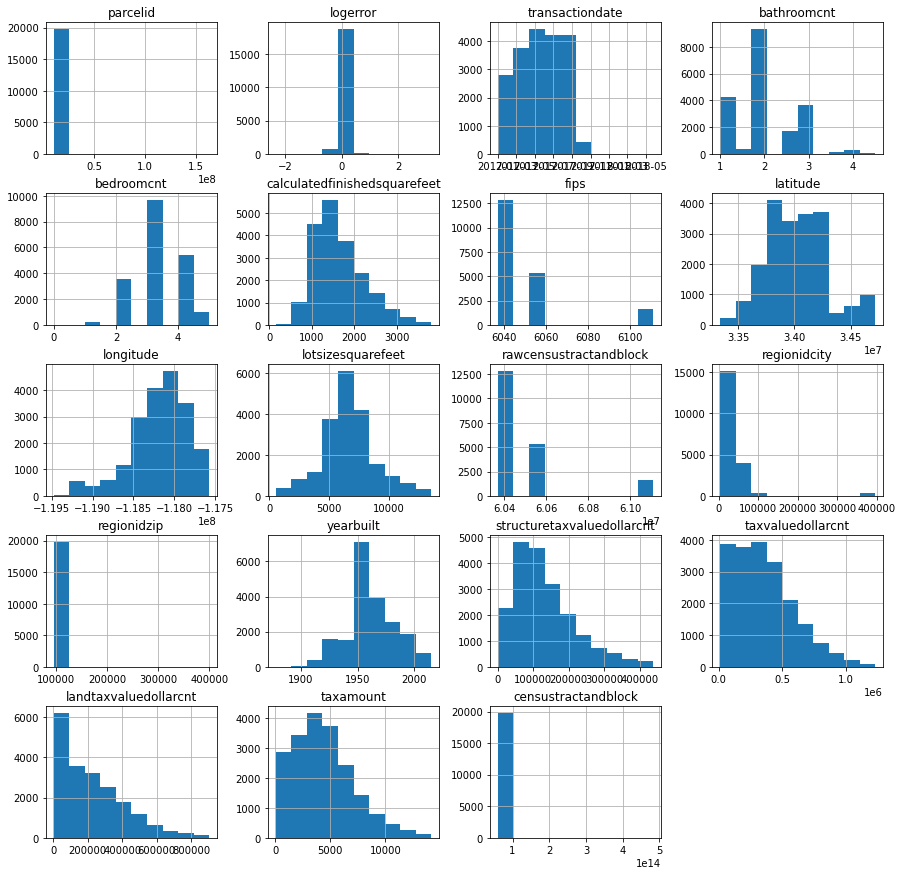

In [51]:
train.hist(figsize=(15, 15))

**Target variable**: logerror

(-1.0, 1.0)

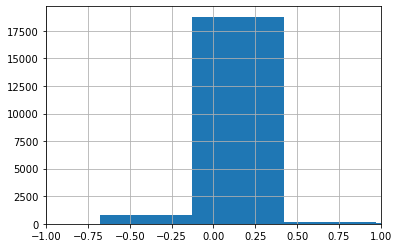

In [52]:
train['logerror'].hist()
plt.xlim(-1,1)

In [56]:
train['logerror'].mean()

0.015454377313674945

(-0.15, 0.15)

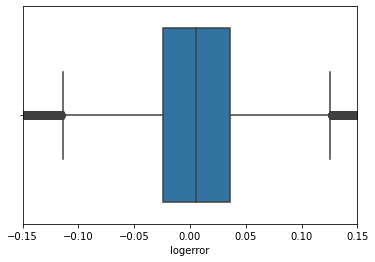

In [53]:
sns.boxplot(data=train, x='logerror')
plt.xlim(-.15,.15)

1. What is the distribution of each of the variables?
2. Does logerror change according to attributes that are part of the house, like number of bed or bathrooms and $ft^2$?
3. Is there a relationship between logerror and attributes dealing with location, like county, coordinates, or region city/zip
4. Is there a relationship between logerror and attibutes dealing with taxes?


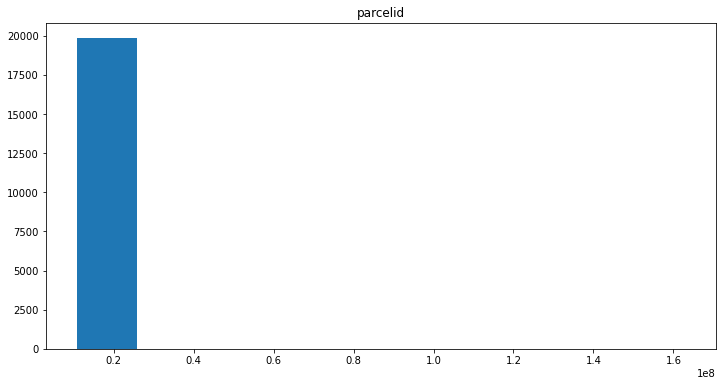

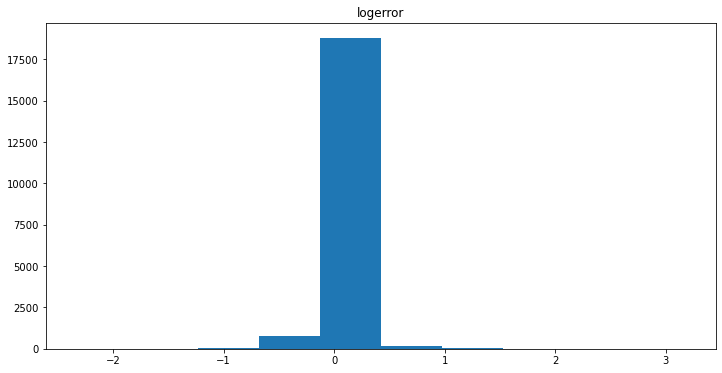

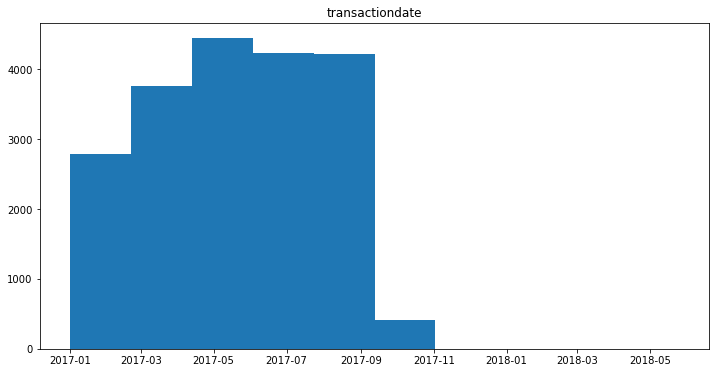

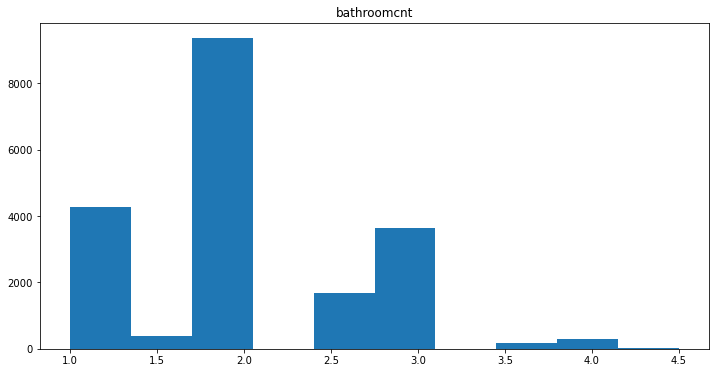

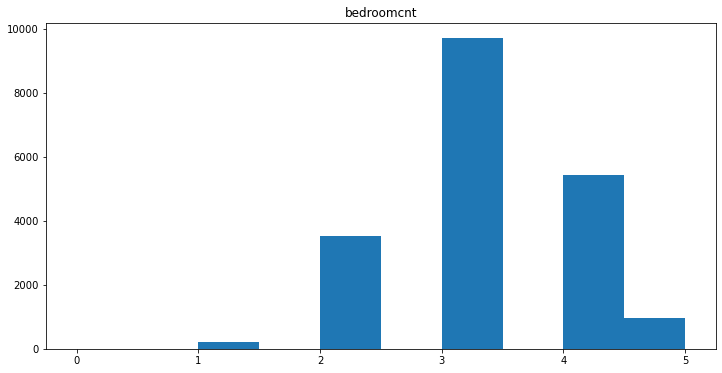

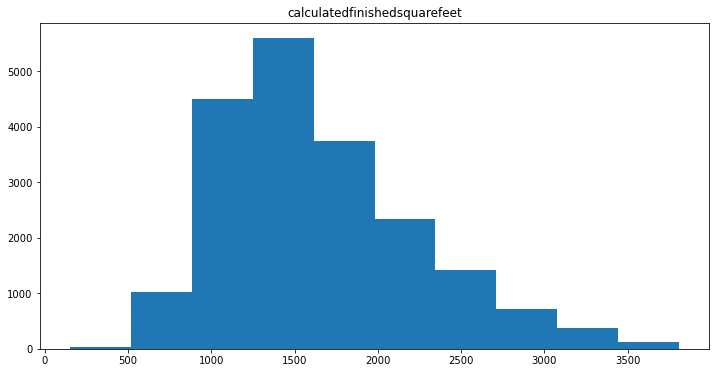

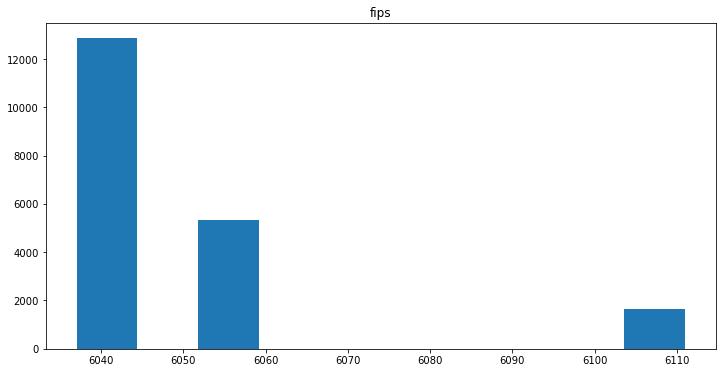

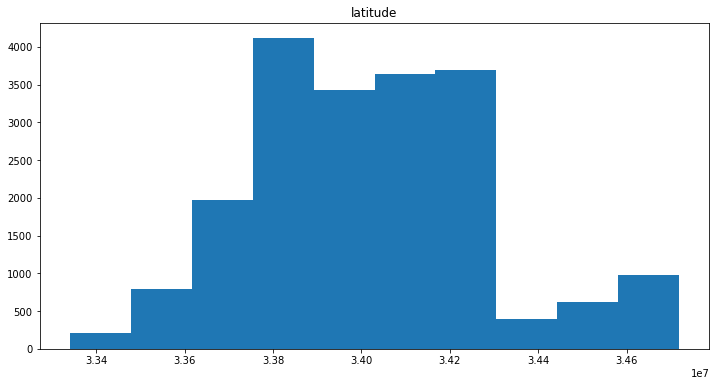

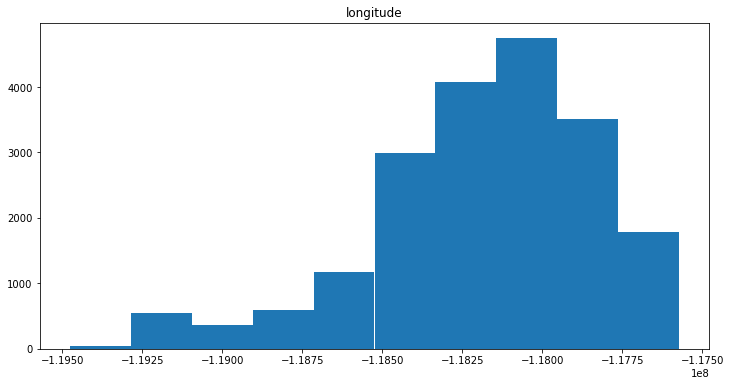

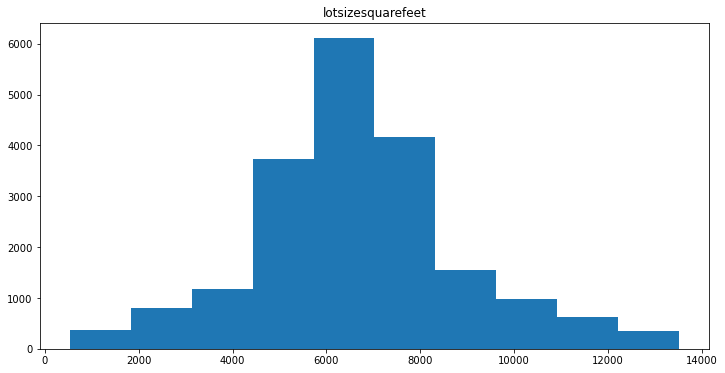

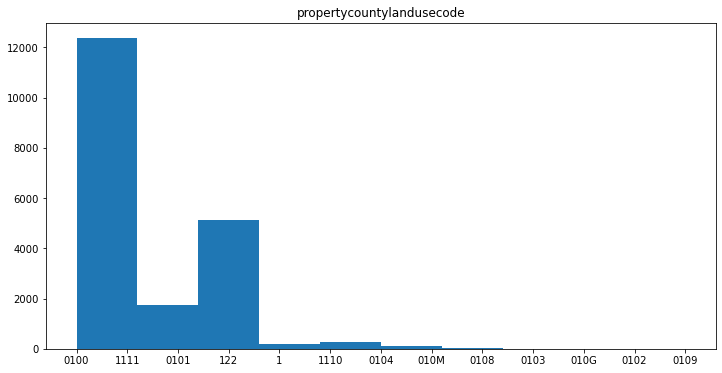

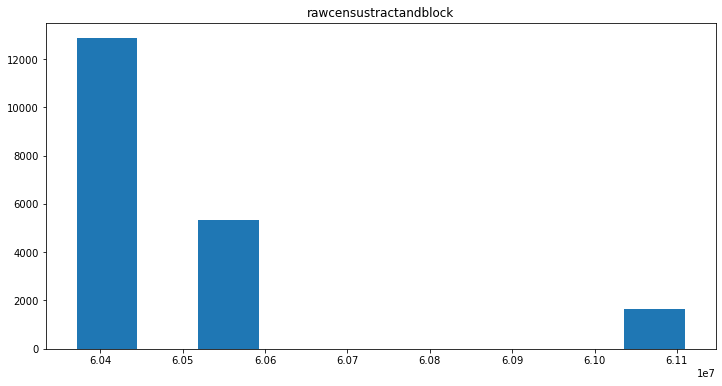

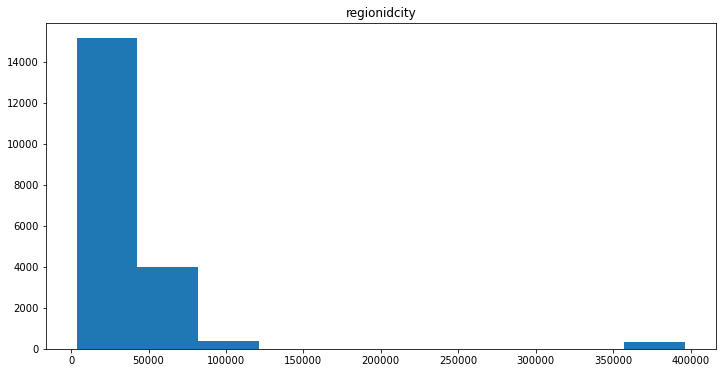

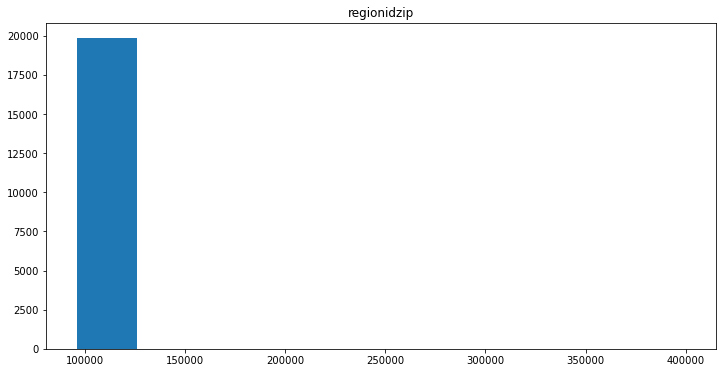

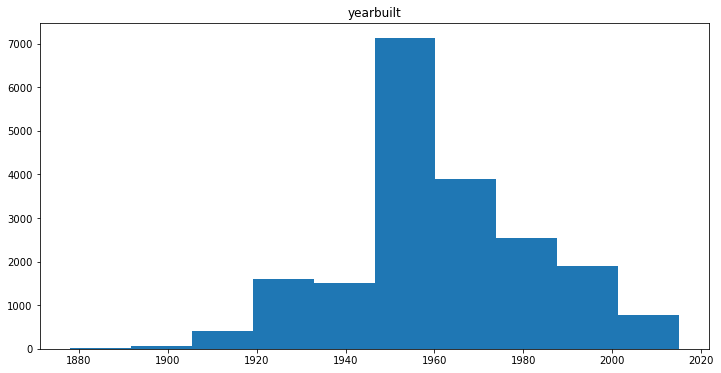

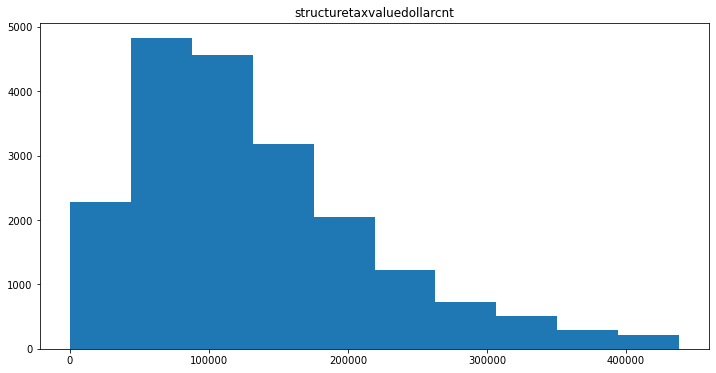

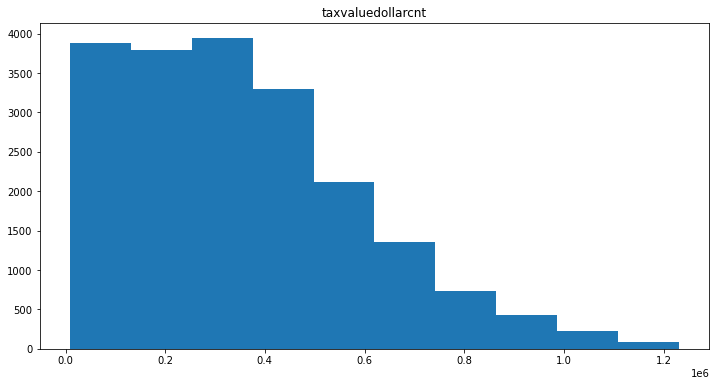

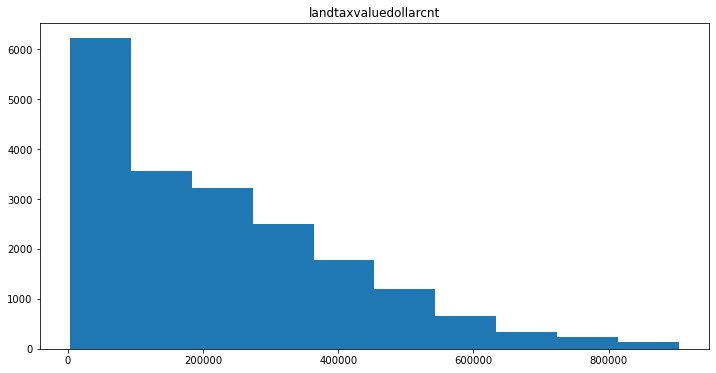

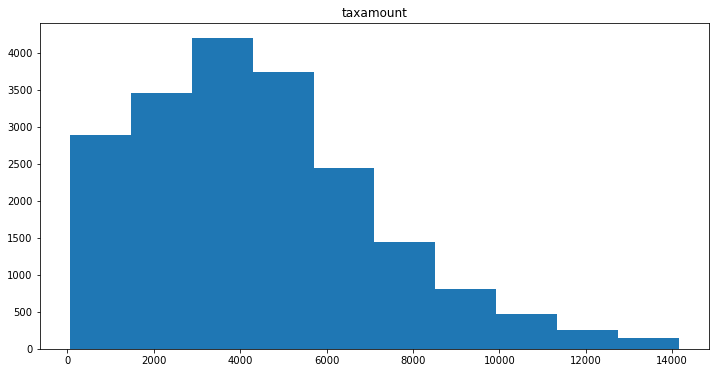

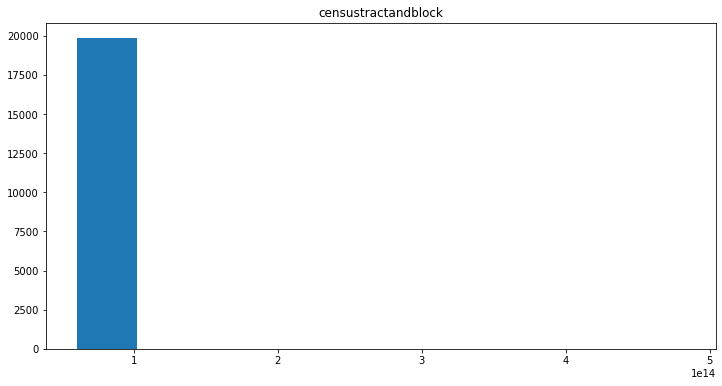

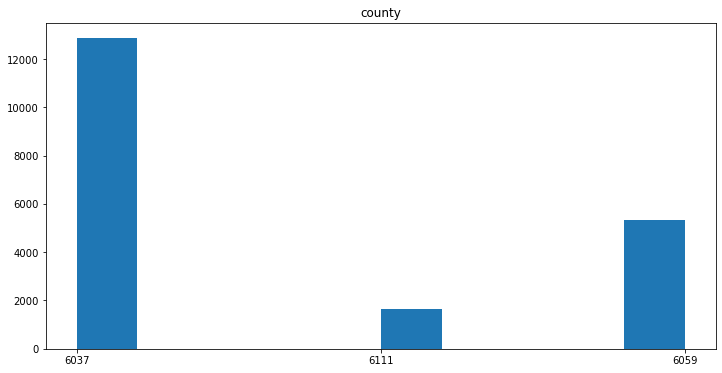

In [54]:
for col in train.columns:
    plt.figure(figsize=(12,6))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

1. What is the distribution of each of the variables?
- logerror appears to have a somewhat normal distribution
- calculatedfinishedsquarefeet, structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, and tax amount skew right
- lotsizesquarefeet appears to have a normal distribution
- yearbuilt has a pretty big spike in the 1950s
- Majority of properties are in Los Angeles County
- if binning may want to bin 9k+ for tax amount, 590k+ for land tax, 800k+ for tax value, 280k+ for structure tax, 2900sqft+ for home area, and 1920 and before for year built

<Figure size 864x432 with 0 Axes>

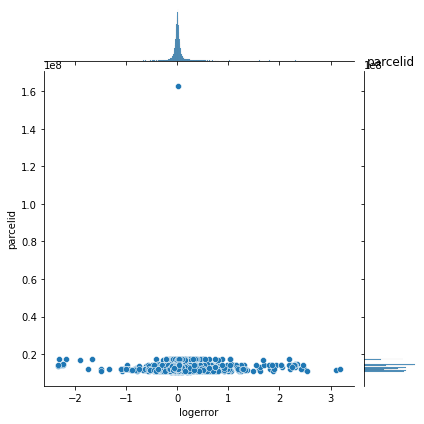

<Figure size 864x432 with 0 Axes>

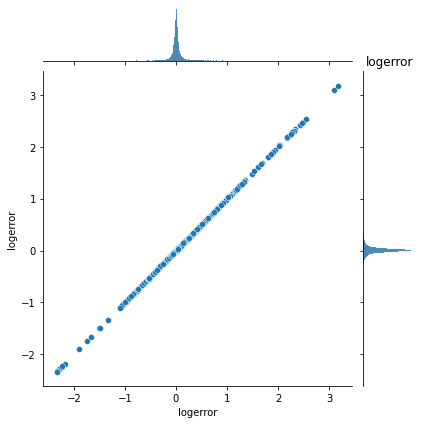

<Figure size 864x432 with 0 Axes>

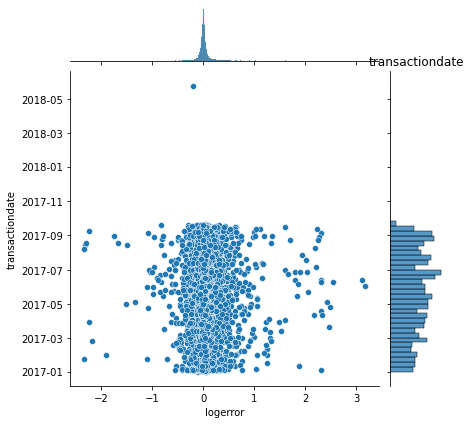

<Figure size 864x432 with 0 Axes>

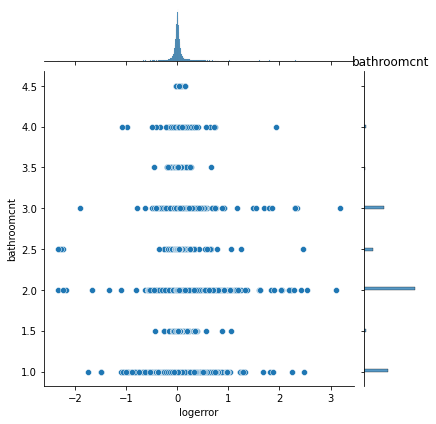

<Figure size 864x432 with 0 Axes>

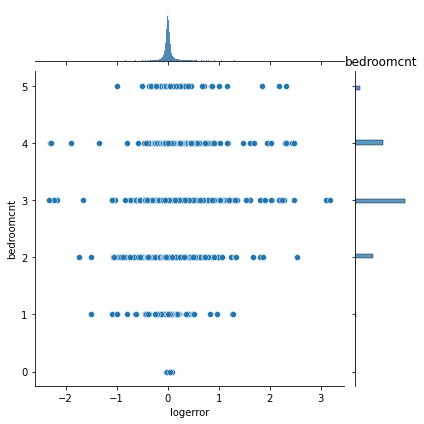

<Figure size 864x432 with 0 Axes>

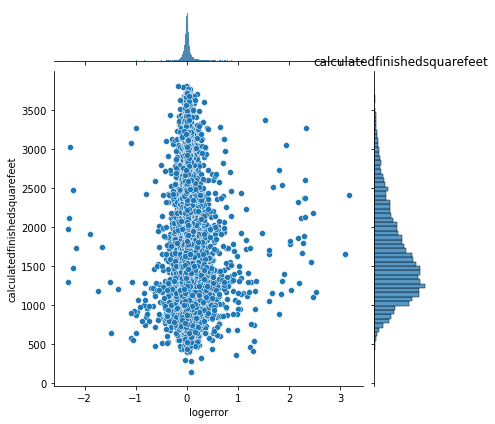

<Figure size 864x432 with 0 Axes>

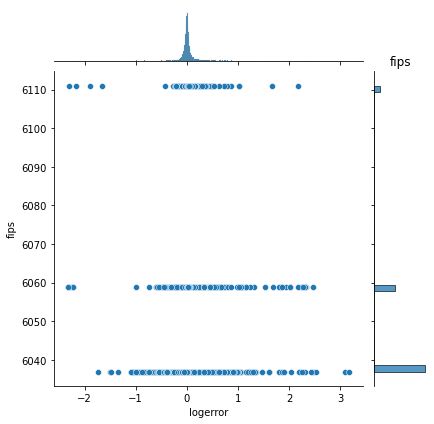

<Figure size 864x432 with 0 Axes>

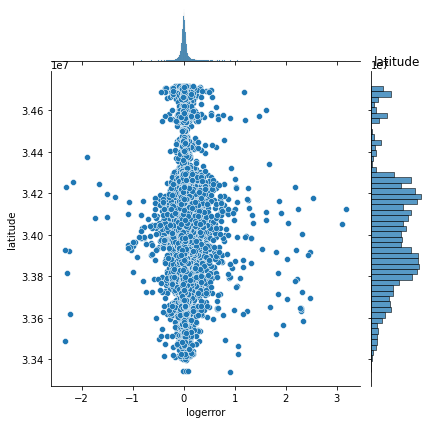

<Figure size 864x432 with 0 Axes>

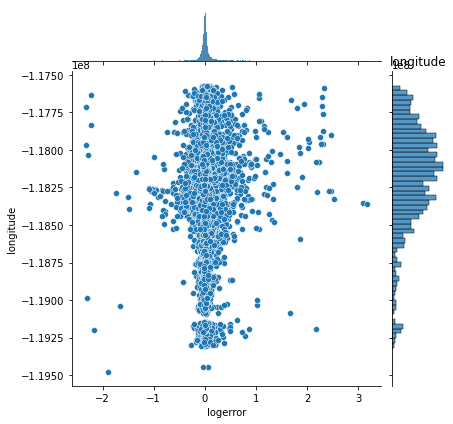

<Figure size 864x432 with 0 Axes>

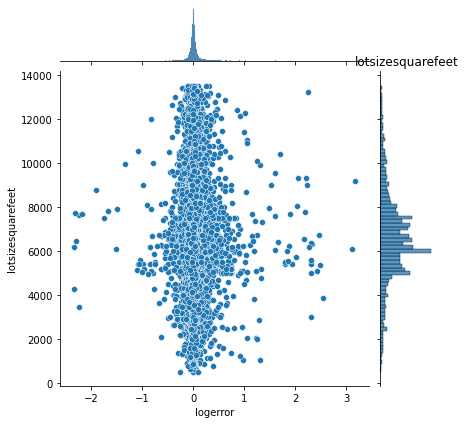

<Figure size 864x432 with 0 Axes>

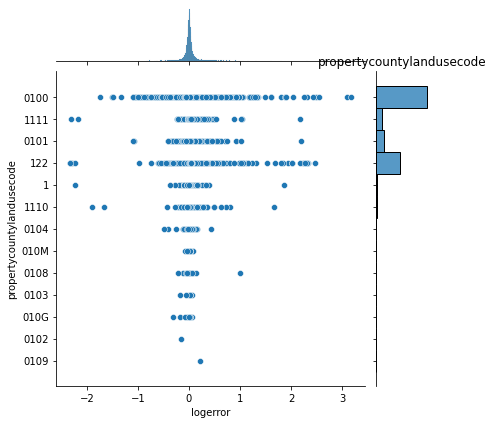

<Figure size 864x432 with 0 Axes>

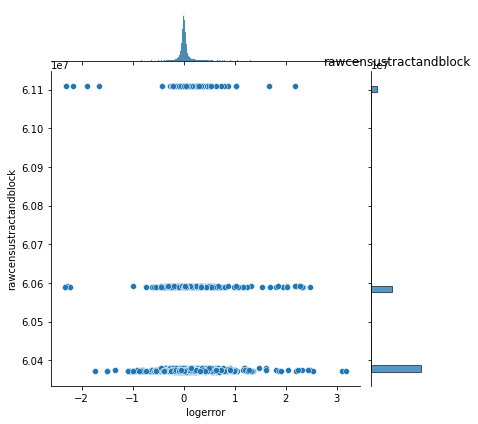

<Figure size 864x432 with 0 Axes>

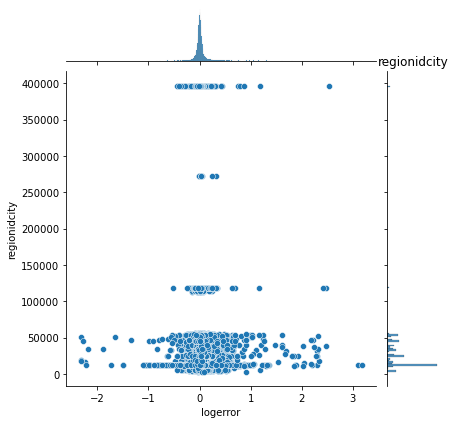

<Figure size 864x432 with 0 Axes>

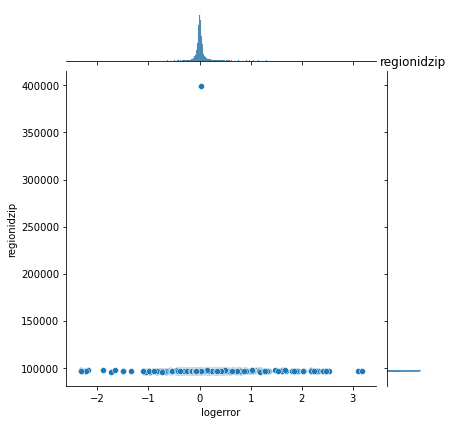

<Figure size 864x432 with 0 Axes>

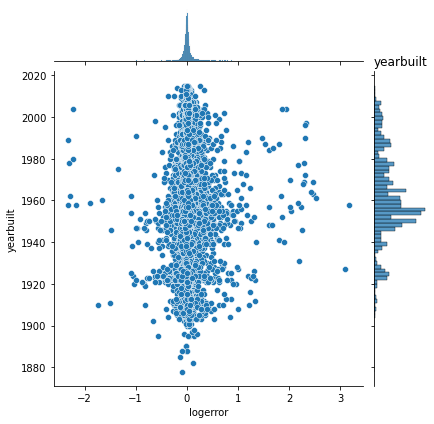

<Figure size 864x432 with 0 Axes>

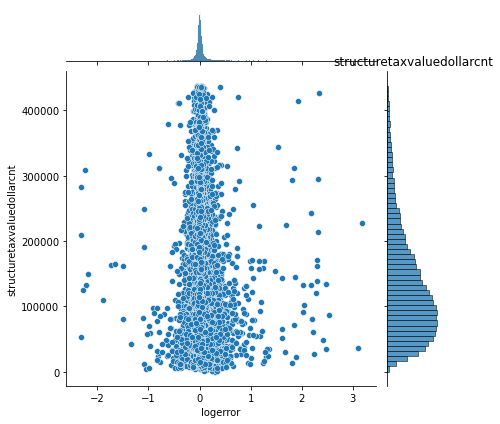

<Figure size 864x432 with 0 Axes>

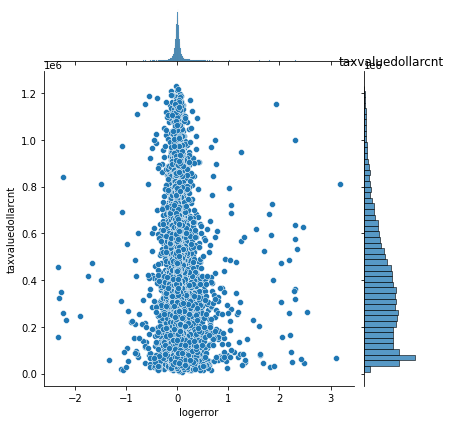

<Figure size 864x432 with 0 Axes>

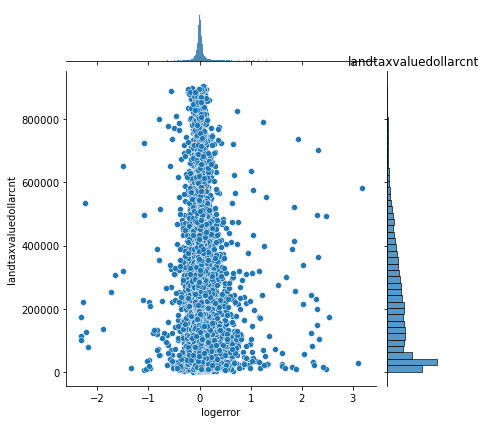

<Figure size 864x432 with 0 Axes>

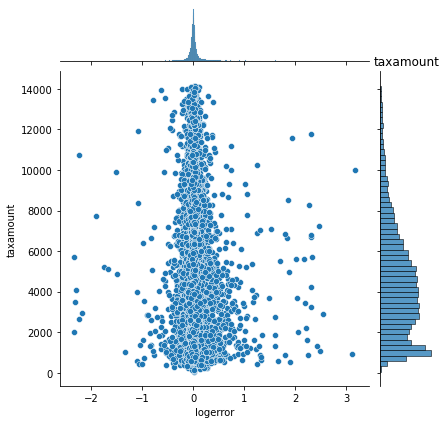

<Figure size 864x432 with 0 Axes>

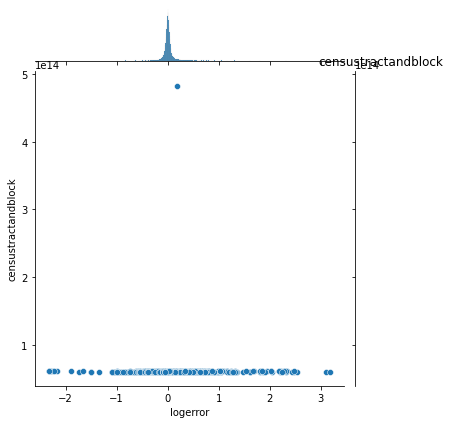

<Figure size 864x432 with 0 Axes>

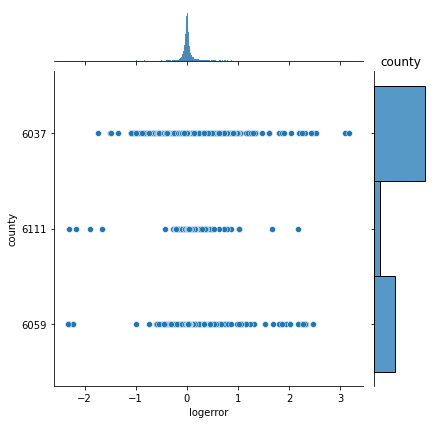

In [55]:
for col in train.columns:
    plt.figure(figsize=(12,6))
    sns.jointplot(train.logerror, train[col])
    plt.title(col)
    plt.show()


2. Does logerror change according to attributes that are part of the house, like number of bed or bathrooms and $ft^2$?
- 

Modeling - See modeling notebook [here](http://localhost:8892/lab/tree/initial_report2.ipynb)